# Multi-class Classification and Neural Networks
For this exercise, we use logistic regression and neural networks to
recognize handwritten digits (from 0 to 9). Automated handwritten digit
recognition is widely used today - from recognizing zip codes (postal codes)
on mail envelopes to recognizing amounts written on bank checks. 
In the first part of the exercise, we extend the previous implemention of 
logistic regression and apply it to one-vs-all classification.

## Datasets
You are given a data set in `ex3data1.mat` that contains 5000 training examples of handwritten digits.  After loading, matrices of the correct dimensions and values will appear in your program’s memory.

There are 5000 training examples in `ex3data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of a digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is "unrolled" into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix $ X $. This gives us a $ 5000 \times 400 $ matrix $ X $ where every row is a training example for a handwritten digit image.

$$
X = \begin{bmatrix}
-(x^{(1)})^T- \\
-(x^{(2)})^T- \\
\vdots \\
-(x^{(m)})^T-
\end{bmatrix}
$$

The second part of the training set is a 5000-dimensional vector $ y $ that contains labels for the training set. In this dataset, the digit zero was mapped to the value 10 in order to make things more compatible with Octave/MATLAB indexing. However, since this implementation is in python which starts indexing at 0, we change the the value back to zero.

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.optimize

plt.style.use('ggplot')

In [47]:
data1 = scipy.io.loadmat('ex3data1.mat')
X1 = data1['X']
y1 = data1['y']
y1[y1==10] = 0
X1.shape, y1.shape

((5000, 400), (5000, 1))

## Visualizing the data
You will begin by visualizing a subset of the training set. We randomly 
select 100 rows from X and passes those rows to the displayData function. This function maps each row to a 20 pixel by
20 pixel grayscale image and displays the images together. Note the need to rotate, then flip the array in order to show correctly.

array([6], dtype=uint8)

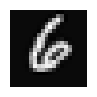

In [50]:
plt.figure(figsize=(1, 1))
n = 3000
array =  np.rot90(np.fliplr(X1[3000].reshape(20, 20)))
plt.imshow(array, cmap='gray')
plt.axis('off')
y1[n]

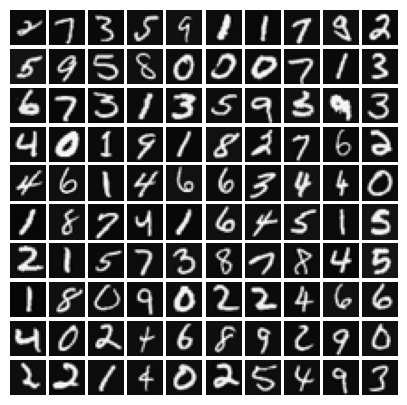

array([[2, 7, 3, 5, 9, 1, 1, 7, 9, 2],
       [5, 9, 5, 8, 0, 0, 0, 7, 1, 3],
       [6, 7, 3, 1, 3, 5, 9, 3, 9, 3],
       [4, 0, 1, 9, 1, 8, 2, 7, 6, 2],
       [4, 6, 1, 4, 6, 6, 3, 4, 4, 0],
       [1, 8, 7, 4, 1, 6, 4, 5, 1, 5],
       [2, 1, 5, 7, 3, 8, 7, 8, 4, 5],
       [1, 8, 0, 9, 0, 2, 2, 4, 6, 6],
       [4, 0, 2, 4, 6, 8, 9, 2, 9, 0],
       [2, 2, 1, 4, 0, 2, 5, 4, 9, 3]], dtype=uint8)

In [52]:
def displayData(X, y, plot_size=10, figsize=5):
    indices = np.random.choice(len(X), plot_size*plot_size, replace=False)
    labels = y[indices]
    selected_images = X[indices]
    fig, axes = plt.subplots(plot_size, plot_size, figsize=(figsize, figsize))
    n = int(np.sqrt(X.shape[1]))
    for i, ax in enumerate(axes.flat):
        rotated_image = np.rot90(np.fliplr((selected_images[i].reshape(n, n))))
        ax.imshow(rotated_image.reshape(20, 20), cmap='gray')
        ax.axis('off')
    plt.subplots_adjust(wspace=figsize/50, hspace=figsize/50)
    plt.show()
    return labels.reshape(plot_size, plot_size)

displayData(X1, y1)

### Vectorizing Logistic Regression

You will be using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, you will need to train 10 separate logistic regression classifiers. To make this training efficient, it is important to ensure that your code is well vectorized. In this section, you will implement a vectorized version of logistic regression that does not employ any for loops. You can use your code in the last exercise as a starting point for this exercise.

#### Vectorizing the Cost Function

We will begin by writing a vectorized version of the cost function. Recall that in (unregularized) logistic regression, the cost function is

$$
J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log(h_\theta(x^{(i)})) - (1 - y^{(i)}) \log(1 - h_\theta(x^{(i)})) \right].
$$

To compute each element in the summation, we have to compute $ h_\theta(x^{(i)}) $ for every example $ i $, where:

$$
h_\theta(x^{(i)}) = g(\theta^T x^{(i)}) \quad \text{and} \quad g(z) = \frac{1}{1 + e^{-z}}
$$

is the sigmoid function. It turns out that we can compute this quickly for all our examples by using matrix multiplication. Let us define $ X $ and $ \theta $ as:

$$
X = 
\begin{bmatrix}
- (x^{(1)})^T - \\
- (x^{(2)})^T - \\
\vdots \\
- (x^{(m)})^T - 
\end{bmatrix}
\quad \text{and} \quad
\theta = 
\begin{bmatrix}
\theta_0 \\
\theta_1 \\
\vdots \\
\theta_n
\end{bmatrix}.
$$

Then, by computing the matrix product $ X\theta $, we have:

$$
X\theta = 
\begin{bmatrix}
- (x^{(1)})^T \theta - \\
- (x^{(2)})^T \theta - \\
\vdots \\
- (x^{(m)})^T \theta -
\end{bmatrix} = 
\begin{bmatrix}
- \theta^T x^{(1)} - \\
- \theta^T x^{(2)} - \\
\vdots \\
- \theta^T x^{(m)} -
\end{bmatrix}.
$$

In the last equality, we used the fact that $ \mathbf{a}^T \mathbf{b} = \mathbf{b}^T \mathbf{a} $ if $ \mathbf{a} $ and $ \mathbf{b} $ are vectors. This allows us to compute the products $ \theta^T x^{(i)} $ for all our examples $ i $ in one line of code.

### Vectorizing the Cost
We write the unregularized cost function `lrCostFunction`. The implementation should use the strategy we presented above to calculate $ \theta^T x^{(i)} $. A fully vectorized version of `lrCostFunction` should not contain any loops.

### Vectorizing the Gradient

Recall that the gradient of the (unregularized) logistic regression cost is a vector where the $ j $-th element is defined as

$$
\frac{\partial J}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x^{(i)}_j.
$$

To vectorize this operation over the dataset, we start by writing out all the partial derivatives explicitly for all $θ_j$. The partial derivatives explicitly for all $\theta_j$:

$$
\begin{bmatrix}
\frac{\partial J}{\partial \theta_0} \\
\frac{\partial J}{\partial \theta_1} \\
\frac{\partial J}{\partial \theta_2} \\
\vdots \\
\frac{\partial J}{\partial \theta_n}
\end{bmatrix}
=
\frac{1}{m}
\begin{bmatrix}
\sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_0^{(i)} \\
\sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_1^{(i)} \\
\sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_2^{(i)} \\
\vdots \\
\sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_n^{(i)}
\end{bmatrix}
= \frac{1}{m} X^T \left( h_\theta(x) - y \right)
$$
$$
where:
\space
h_\theta(x) - y = 
\begin{bmatrix} 
h_\theta\left( x^{(1)} \right) - y^{(1)} \\
h_\theta\left( x^{(2)} \right) - y^{(2)} \\
\vdots \\
h_\theta\left( x^{(m)} \right) - y^{(m)}
\end{bmatrix}
$$

Note that $x^{(i)}$ is a vector, while $h_\theta\left( x^{(i)} \right) - y^{(i)}$ is a scalar (single number). To understand the last step of the derivation, let $\beta_i = ( h_\theta(x^{(i)}) - y^{(i)} )$, and observe that:

$$
\beta_i x^{(i)} 
= 
\begin{bmatrix}
| & | & & | \\
x^{(1)} & x^{(2)} & \dots & x^{(m)} \\
| & | & & |
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_m
\end{bmatrix} = X^T \beta,
$$

where the values $\beta_i = \left( h_\theta(x^{(i)}) - y^{(i)} \right)$. The expression above allows us to compute all the partial derivatives without any loops. We implement Equation (1) to compute the correct vectorized gradient.




In [148]:
def lrHypothesis(theta, X):
    return 1 / (1 + np.exp(-X @ theta))

def lrCostFunction(X, y, epsilon=1e-3):
    def cost(theta):
        m = len(y)
        h = lrHypothesis(theta, X)
        return np.sum(-y*np.log(h+epsilon) - (1-y)*np.log(1-h+epsilon)) / m
    return cost

def lrGradient(X, y):
    def gradient(theta):
        m = len(y)
        h = lrHypothesis(theta, X)
        return ((1 / m) * (h - y) @ X)
    return gradient

In [150]:
theta0 = np.zeros(400)  
theta1 = np.ones(400)
lrHypothesis(theta0, X1)
lrCostFunction(X1, y1)(theta0), lrCostFunction(X1, y1)(theta1)

(-85011.34888137144, 6953782.382196715)

In [151]:
digitsCost=lrCostFunction(X1, y1)
digitsGradient=lrGradient(X1, y1)


### Vectorizing Regularized Logistic Regression

After you have implemented vectorization for logistic regression, you will now add regularization to the cost function. Recall that for regularized logistic regression, the cost function is defined as:

$$
J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left( -y^{(i)} \log(h_\theta(x^{(i)})) - (1 - y^{(i)}) \log(1 - h_\theta(x^{(i)})) \right) + \frac{\lambda}{2m} \sum_{j=1}^{n} \theta_j^2.
$$

Note that you should not be regularizing $ \theta_0 $, which is used for the bias term. Correspondingly, the partial derivative of the regularized logistic regression cost with respect to $ \theta_j $ is defined as:

$$
\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_0^{(i)}
\space for \space j = 0
$$

$$
\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)} + \frac{\lambda}{m} \theta_j \space for \space j \geq 1
$$

Now, modify your code in the `lrCostFunction` to account for regularization. Once again, you should not introduce any loops into your code.

## One-vs-all Classification

In this part of the exercise, you will implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the $ K $ classes in our dataset (Figure 1). In the handwritten digits dataset, $ K = 10 $, but your code should work for any value of $ K $.

You should now complete the code in `oneVsAll.m` to train one classifier for each class. In particular, your code should return all the classifier parameters in a matrix $ \Theta \in \mathbb{R}^{K \times (N+1)} $, where each row of $ \Theta $ corresponds to the learned logistic regression parameters for one class. You can do this with a "for"-loop from $ 1 $ to $ K $, training each classifier independently.

Note that the $ y $ argument to this function is a vector of labels from $ 1 $ to $ 10 $, where we have mapped the digit "0" to the label $ 10 $ (to avoid confusion with indexing).

When training the classifier for class $ k \in \{1, \ldots, K\} $, you will want an $ m $-dimensional vector of labels $ y $, where:

$$
y_j =
\begin{cases}
1 & \text{if } j\text{-th training instance belongs to class } k \\
0 & \text{if it belongs to a different class}
\end{cases}
$$

You may find logical arrays helpful for this task.


In [157]:
def oneVsAll(X, y):
    thetas = []
    theta0 = np.zeros(X.shape[1])
    for k in range(10):
        y_k = np.float32(y==k)
        cost = lrCostFunction(X, y_k)
        gradient = lrGradient(X, y_k)
        objective = scipy.optimize.minimize(fun=cost, jac=gradient, x0=theta0)
        print(objective.x)
        thetas.append(objective.x)
    return thetas
    

In [137]:
oneVsAll(X1, y1)

ValueError: shapes (400,5000) and (400,5000) not aligned: 5000 (dim 1) != 400 (dim 0)

In [ ]:
k=0
theta0 = np.zeros(X1.shape[1])
y_k = np.float32(y1==k)
cost = lrCostFunction(X1, y_k)
gradient = lrGradient(X1, y_k)
objective = scipy.optimize.minimize(fun=cost, jac=gradient, x0=theta0)

In [140]:
theta0.shape

(400,)

In [142]:
cost(theta0)

3455.7458894861056

In [146]:
gradient(theta0)[0]

array([ 0.00000000e+00,  0.00000000e+00, -7.74530186e-08,  9.40902437e-07,
        1.79007864e-06, -5.86512034e-05, -7.26926011e-05, -4.02459167e-05,
       -9.71628200e-06, -2.18079282e-05, -7.05070976e-06,  5.42333538e-06,
        1.17534888e-05,  2.08794594e-05,  3.26743345e-05,  2.35833248e-05,
        6.85661765e-06,  4.63698993e-08, -7.31889978e-08,  0.00000000e+00,
       -2.46800109e-08,  1.99142157e-07,  8.34097672e-07,  2.56452717e-06,
        1.42989907e-05, -8.20161952e-05, -2.98347610e-04, -4.47927389e-04,
       -3.53500706e-04, -1.34235160e-04,  5.08286237e-05,  1.07588366e-04,
        1.22462028e-04,  1.44337163e-04,  4.72887646e-05,  4.79718988e-06,
        2.62880753e-05,  2.72380695e-05,  3.87105120e-06,  8.85893246e-07,
        2.11721903e-07, -2.19507970e-06,  1.01278496e-05, -6.81754837e-05,
       -4.25397106e-04, -1.41530164e-03, -2.43250783e-03, -2.72626481e-03,
       -2.02807562e-03, -9.81235352e-04, -6.25010594e-04, -6.15115590e-04,
       -1.64897029e-03, -